#**Exploratory Data Analysis**

In [ ]:
!pip install kats

### **Installation and Import**

In [1]:
# Import the packages
import pandas as pd
import numpy as np
import plotly.express as px
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# from kats.consts import TimeSeriesData
# from kats.detectors.robust_stat_detection import RobustStatDetector
# from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
# from kats.detectors.cusum_detection import CUSUMDetector

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/input.xlsx')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/Insured_Unemployment_Rate.xlsx')

In [2]:
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/tfl-journeys-type.xlsx')

In [3]:
df = df.dropna()

In [4]:
df.head()

,Date,Values
0,2010-04-01,185.4
1,2010-05-01,175.9
2,2010-06-01,183.4
3,2010-07-01,160.4
4,2010-08-01,175.8


## **Visualizing the TS Data**

In [5]:
viz_df = df.copy()

**Line Plot**

In [6]:
fig = px.line(viz_df, x='Date', y="Values")
fig.show()

**Box Plot**

In [7]:
viz_df['year'] = pd.DatetimeIndex(viz_df['Date']).year

In [8]:
fig = px.box(viz_df,x="year",y="Values")
fig.show()

**Seasonal decomposition**

In [9]:
stl_df = df.set_index('Date')

In [10]:
stl_df.head()

,Values
Date,
2010-04-01,185.4
2010-05-01,175.9
2010-06-01,183.4
2010-07-01,160.4
2010-08-01,175.8


In [11]:
result = seasonal_decompose(stl_df['Values'],freq = 12,model='additive')

In [12]:
stl_df['Seasonal'] = result.seasonal
stl_df['Trend'] = result.trend
stl_df['Residual'] = result.resid
stl_df = stl_df.reset_index()

In [13]:
#Seasonal plot 
fig = px.line(stl_df,x = 'Date', y = 'Seasonal')
fig.show()

In [14]:
#Trend plot 
fig = px.line(stl_df,x = 'Date', y = 'Trend')
fig.show()

In [15]:
#Residual plot 
fig = px.line(stl_df,x = 'Date', y = 'Residual')
fig.show()

## **ADF Test**

In [16]:
adf_test_df = df.set_index('Date').squeeze()

In [17]:
sales_val = adf_test_df.values

In [18]:
result = adfuller(sales_val)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.214262
p-value: 0.201110
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579


### Inference:
ADF Statistic: **-2.544328** is  less than Critical Values 1%: **-3.452** which suggests the possibility to reject the null hypothesis making the series stationary

But the p-value is above the threshold of 0.05. Hence running KPSS test to validate the results

## **KPSS Test**

In [19]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')

In [20]:
#Stationarity around mean
kpss_test(sales_val)

KPSS Statistic: 0.5843786604311763
p-value: 0.02405648541534761
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'



In [ ]:
#Stationarity around Determinstic Trend
kpss_test(sales_val, regression='ct')

KPSS Statistic: 0.31526870122333456
p-value: 0.01
num lags: 28
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



### Inference:
KPSS Statistic: The p-value is consitently below the threshold (0.05) at **0.02** and **0.04** which suggests that we cannont reject the null hypothesis and the series is considered to be **Non-Stationary**

## **Visualizing using ACF and PACF plots**

### **ACF Plot**

In [21]:
viz_corr_df = df.copy()
viz_corr_df = viz_corr_df.set_index('Date')

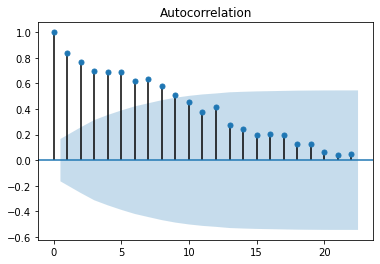

In [22]:
plot_acf(viz_corr_df)
pyplot.show()

### **PACF Plot**

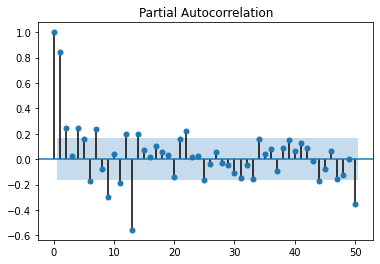

In [23]:
plot_pacf(viz_corr_df, lags=50)
pyplot.show()

## **Changepoint Detection using KATS**

In [ ]:
kats_df = df.rename(columns={'Date':'time', 'SalesVolume':'value'})

NameError: ignored

In [ ]:
tsd = TimeSeriesData(kats_df)

NameError: ignored

### **BOCPDetector**

/usr/local/lib/python3.7/dist-packages/ax/core/parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/usr/local/lib/python3.7/dist-packages/ax/core/parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



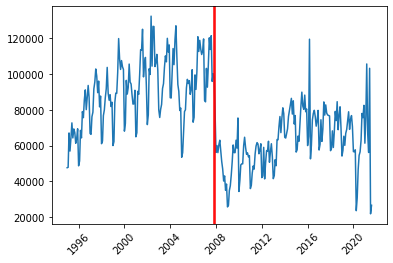

In [ ]:
# Initialize the detector
detector = BOCPDetector(tsd)

changepoints = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL 
)

# Plot the data
pyplot.xticks(rotation=45)
detector.plot(changepoints)
pyplot.show()

### **RobustStatDetector**

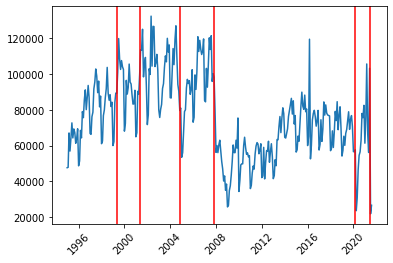

In [ ]:
detector = RobustStatDetector(tsd)
change_points = detector.detector()

pyplot.xticks(rotation=45)
detector.plot(change_points)
pyplot.show()